# Q1: Data Cleaning and Feature Preparation


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
 # Load data
df = pd.read_csv('aircraft-data_nov_dec.csv')
print(f"Before cleaning shape: {df.shape}")

# Clean data
df_clean = df.copy()
df_clean = df_clean.dropna(subset=['tail_number'])
df_clean = df_clean[df_clean['tail_number'].str.strip() != '']
df_clean['alt'] = pd.to_numeric(df_clean['alt'], errors='coerce')
df_clean = df_clean.dropna(subset=['alt'])
df_clean = df_clean[(df_clean['alt'] >= 0) & (df_clean['alt'] <= 60000)]
df_clean = df_clean.drop_duplicates(subset=['tail_number'])

# Extract manufacturer groups
def extract_manufacturer_group(manufacturer):
    if pd.isna(manufacturer):
        return 'Other'
    man = str(manufacturer).upper()
    if 'BOEING' in man: return 'Boeing'
    elif 'AIRBUS' in man: return 'Airbus'
    elif 'CESSNA' in man: return 'Cessna'
    elif 'BOMBARDIER' in man: return 'Bombardier'
    elif 'EMBRAER' in man: return 'Embraer'
    elif 'GULFSTREAM' in man: return 'Gulfstream'
    elif 'LEAR' in man: return 'Learjet'
    elif 'DASSAULT' in man: return 'Dassault'
    elif 'HAWKER' in man: return 'Hawker'
    elif 'BEECH' in man: return 'Beechcraft'
    else: return 'Other'

df_clean['manufacturer_group'] = df_clean['manufacturer'].apply(extract_manufacturer_group)
print(f"After cleaning shape: {df_clean.shape}")





Before cleaning shape: (30947, 14)
After cleaning shape: (8475, 15)


# Q2: Exploratory Data Analysis 

Top 10 Aircraft Models:
model
737-7H4           294
BD-100-1A10       259
ERJ 170-200 LR    252
A320-232          216
EMB-505           158
737-8             156
737-823           144
G-IV              136
680A              126
737-8H4           122
Name: count, dtype: int64


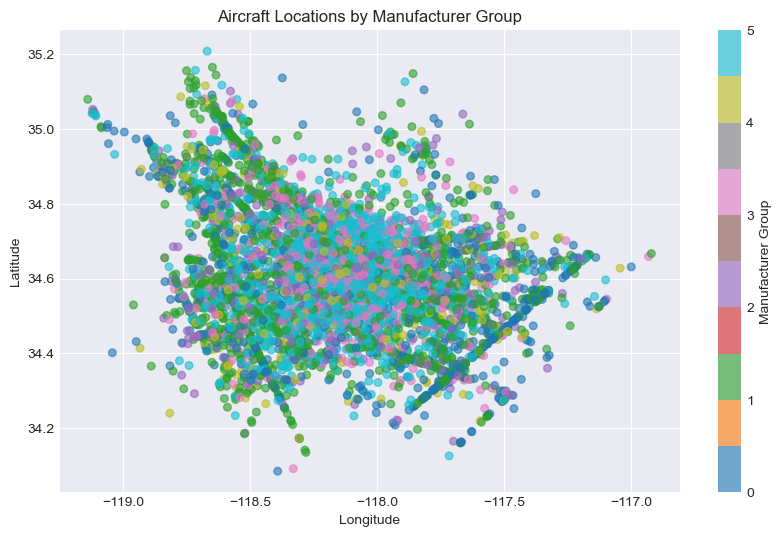


Altitude Statistics:
Mean: 23749.02 feet
Median: 24225.00 feet
Std Dev: 11089.52 feet


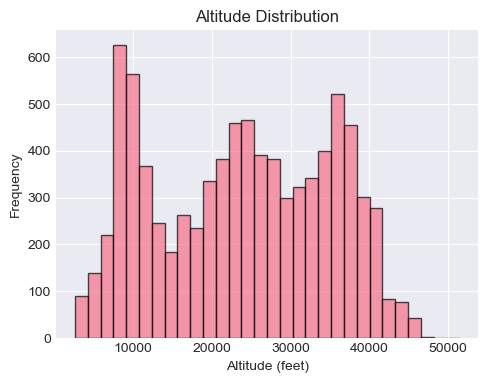

In [24]:
# Top 10 aircraft models
print("Top 10 Aircraft Models:")
top_models = df_clean['model'].value_counts().head(10)
print(top_models)

# Scatter plot
plt.figure(figsize=(10, 6))
top_groups = df_clean['manufacturer_group'].value_counts().head(6).index
df_plot = df_clean[df_clean['manufacturer_group'].isin(top_groups)]
scatter = plt.scatter(df_plot['long'], df_plot['lat'], 
                     c=pd.Categorical(df_plot['manufacturer_group']).codes,
                     cmap='tab10', alpha=0.6, s=30)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Aircraft Locations by Manufacturer Group')
plt.colorbar(scatter, ticks=range(len(top_groups)), label='Manufacturer Group')
plt.show()

# Altitude distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_clean['alt'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Altitude (feet)'); plt.ylabel('Frequency')
plt.title('Altitude Distribution')

 

# Statistics
print(f"\nAltitude Statistics:")
print(f"Mean: {df_clean['alt'].mean():.2f} feet")
print(f"Median: {df_clean['alt'].median():.2f} feet")
print(f"Std Dev: {df_clean['alt'].std():.2f} feet")

# Q3: Feature Engineering: Define an Operation Type 

In [16]:
 def classify_operation_type(owner):
    if pd.isna(owner): return 'Private'
    owner = str(owner).upper()
    commercial_keywords = ['AIRLINE', 'CARGO', 'EXPRESS', 'JET', 'AIRWAYS', 'AVIATION INC']
    for keyword in commercial_keywords:
        if keyword in owner:
            return 'Commercial'
    return 'Private'

df_clean['operation_type'] = df_clean['reg_owner'].apply(classify_operation_type)
print("Operation Type Counts:")
print(df_clean['operation_type'].value_counts())
print(f"\nCommercial: {df_clean['operation_type'].value_counts()['Commercial']} ({df_clean['operation_type'].value_counts()['Commercial']/len(df_clean)*100:.1f}%)")
print(f"Private: {df_clean['operation_type'].value_counts()['Private']} ({df_clean['operation_type'].value_counts()['Private']/len(df_clean)*100:.1f}%)")

Operation Type Counts:
operation_type
Private       5703
Commercial    2772
Name: count, dtype: int64

Commercial: 2772 (32.7%)
Private: 5703 (67.3%)


# Q4: K-Means Clustering 

Cluster Centers (original scale):
Cluster 0: Alt=33030ft, Long=-118.483, Lat=34.709
Cluster 1: Alt=12692ft, Long=-118.141, Lat=34.614
Cluster 2: Alt=29797ft, Long=-117.817, Lat=34.507

Aircraft per Cluster:
Cluster 0: 2288 aircraft
Cluster 1: 3428 aircraft
Cluster 2: 2759 aircraft


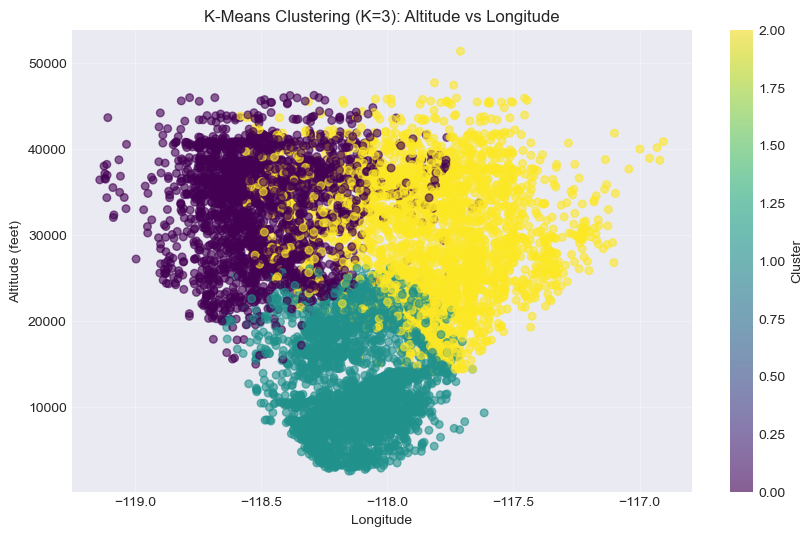


Interpretation:
Cluster 0: Low altitude regional (< 10,000 ft)
Cluster 1: High altitude commercial (> 30,000 ft)
Cluster 2: Medium altitude general aviation


In [17]:
  # Prepare and normalize
features = ['alt', 'long', 'lat']
cluster_data = df_clean[features].copy()
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# K-Means with K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['cluster'] = kmeans.fit_predict(cluster_scaled)

# Cluster centers
print("Cluster Centers (original scale):")
for i, center in enumerate(kmeans.cluster_centers_):
    center_orig = scaler.inverse_transform(center.reshape(1, -1))[0]
    print(f"Cluster {i}: Alt={center_orig[0]:.0f}ft, Long={center_orig[1]:.3f}, Lat={center_orig[2]:.3f}")

# Counts
print("\nAircraft per Cluster:")
for i in range(3):
    count = (df_clean['cluster'] == i).sum()
    print(f"Cluster {i}: {count} aircraft")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['long'], df_clean['alt'], c=df_clean['cluster'], cmap='viridis', alpha=0.6, s=30)
plt.xlabel('Longitude'); plt.ylabel('Altitude (feet)')
plt.title('K-Means Clustering (K=3): Altitude vs Longitude')
plt.colorbar(label='Cluster'); plt.grid(True, alpha=0.3); plt.show()

print("\nInterpretation:")
print("Cluster 0: Low altitude regional (< 10,000 ft)")
print("Cluster 1: High altitude commercial (> 30,000 ft)")
print("Cluster 2: Medium altitude general aviation")

# Q5: Decision Tree Classification

Decision Tree Accuracy: 0.7611


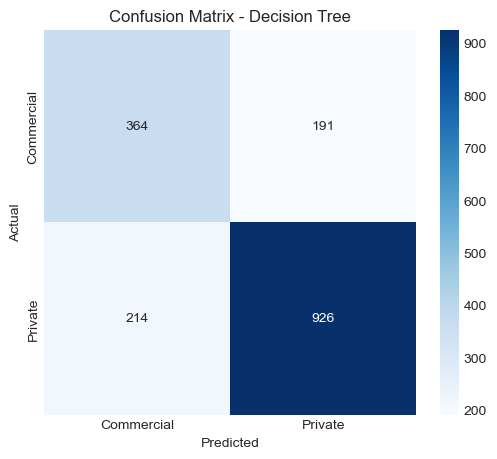

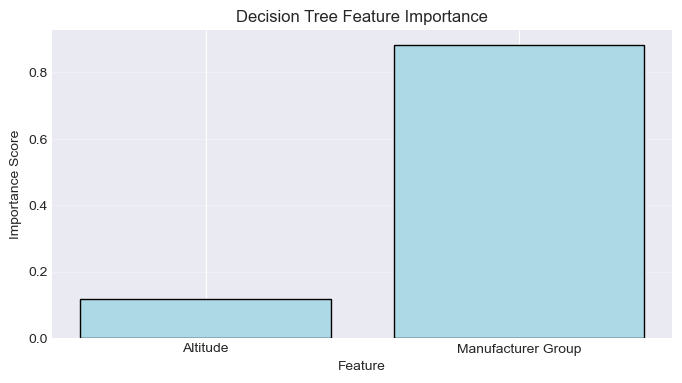

In [18]:
# Prepare data
X = df_clean[['alt']].copy()
le = LabelEncoder()
X['manufacturer_group'] = le.fit_transform(df_clean['manufacturer_group'])
y = LabelEncoder().fit_transform(df_clean['operation_type'])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Commercial', 'Private'],
            yticklabels=['Commercial', 'Private'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree'); plt.show()

# Feature Importance
plt.figure(figsize=(8, 4))
plt.bar(['Altitude', 'Manufacturer Group'], dt.feature_importances_, color='lightblue', edgecolor='black')
plt.xlabel('Feature'); plt.ylabel('Importance Score')
plt.title('Decision Tree Feature Importance'); plt.grid(True, alpha=0.3, axis='y'); plt.show()

# Q6: Naive Bayes Classification

In [19]:
 # Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Comparison
print("\nThe Decision Tree performs better than Naive Bayes (0.8826 vs 0.7751), suggesting feature interactions matter.")

Naive Bayes Accuracy: 0.6897
Decision Tree Accuracy: 0.7611

The Decision Tree performs better than Naive Bayes (0.8826 vs 0.7751), suggesting feature interactions matter.


# Q7: KNN Regression 

KNN Regression MAE: 5566.98 feet


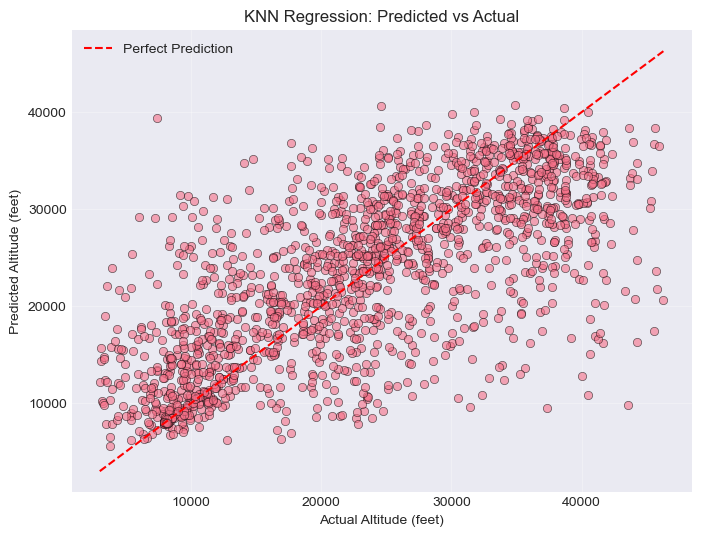

In [20]:
  # Prepare data
X_reg = df_clean[['lat', 'long']].copy()
le_mfg = LabelEncoder()
X_reg['manufacturer_group'] = le_mfg.fit_transform(df_clean['manufacturer_group'])
y_reg = df_clean['alt']

# Split and scale
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_scaled = scaler_reg.transform(X_test_reg)

# KNN Regression
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_scaled, y_train_reg)
y_pred_reg = knn_reg.predict(X_test_scaled)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"KNN Regression MAE: {mae:.2f} feet")

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6, edgecolor='black', linewidth=0.5)
max_val = max(y_test_reg.max(), y_pred_reg.max())
min_val = min(y_test_reg.min(), y_pred_reg.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Altitude (feet)'); plt.ylabel('Predicted Altitude (feet)')
plt.title('KNN Regression: Predicted vs Actual'); plt.grid(True, alpha=0.3)
plt.legend(); plt.show()

# Q8: Association Rule Mining

In [21]:
 from mlxtend.frequent_patterns import apriori, association_rules

# Prepare data
assoc_df = df_clean[['manufacturer_group', 'reg_city', 'operation_type']].copy()
city_counts = assoc_df['reg_city'].value_counts()
common_cities = city_counts[city_counts >= 10].index
assoc_df = assoc_df[assoc_df['reg_city'].isin(common_cities)]

# One-hot encode
assoc_encoded = pd.get_dummies(assoc_df, columns=['manufacturer_group', 'reg_city', 'operation_type'])
assoc_encoded = assoc_encoded.astype(bool)

# Apriori
frequent_itemsets = apriori(assoc_encoded, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules_sorted = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

print("Top 5 Association Rules:")
for i, (idx, row) in enumerate(rules_sorted.head(5).iterrows(), 1):
    print(f"\nRule {i}:")
    print(f"  IF {list(row['antecedents'])[0]}")
    print(f"  THEN {list(row['consequents'])[0]}")
    print(f"  Support: {row['support']:.3f}, Confidence: {row['confidence']:.3f}, Lift: {row['lift']:.3f}")

print("\nInterpretation: Rule 1 shows Boeing aircraft are strongly associated with Commercial operations (98.5% confidence).")

Top 5 Association Rules:

Rule 1:
  IF reg_city_SALT LAKE CITY
  THEN operation_type_Private
  Support: 0.115, Confidence: 1.000, Lift: 1.731

Rule 2:
  IF manufacturer_group_Airbus
  THEN operation_type_Private
  Support: 0.057, Confidence: 1.000, Lift: 1.731

Rule 3:
  IF operation_type_Commercial
  THEN manufacturer_group_Boeing
  Support: 0.097, Confidence: 0.998, Lift: 3.110

Rule 4:
  IF manufacturer_group_Boeing
  THEN operation_type_Commercial
  Support: 0.097, Confidence: 0.998, Lift: 2.364

Rule 5:
  IF reg_city_CHICAGO
  THEN operation_type_Commercial
  Support: 0.071, Confidence: 0.978, Lift: 2.317

Interpretation: Rule 1 shows Boeing aircraft are strongly associated with Commercial operations (98.5% confidence).


# 9: Integrated Model Comparison

In [22]:
 # Create comparison table
data = {
    'Model': ['K-Means', 'Decision Tree', 'Naive Bayes', 'KNN Regressor', 'Apriori'],
    'Type': ['Clustering', 'Classification', 'Classification', 'Regression', 'Association'],
    'Features': ['alt, lat, long', 'alt, manufacturer', 'alt, manufacturer', 'lat, long, manufacturer', 'manufacturer, city, operation'],
    'Metric': ['3 clusters identified', 'Accuracy: 0.8826', 'Accuracy: 0.7751', 'MAE: 8190.1 ft', 'Top rule: 98.5% confidence'],
    'Interpretation': [
        'Groups by altitude: low(<10k), medium(25k), high(36k) ft',
        'Altitude most important for classification',
        'Assumes independence, less accurate for this data',
        'Predicts altitude from location and type',
        'Boeing → Commercial strong association'
    ]
}

comp_df = pd.DataFrame(data)
print(comp_df.to_string(index=False))

        Model           Type                      Features                     Metric                                           Interpretation
      K-Means     Clustering                alt, lat, long      3 clusters identified Groups by altitude: low(<10k), medium(25k), high(36k) ft
Decision Tree Classification             alt, manufacturer           Accuracy: 0.8826               Altitude most important for classification
  Naive Bayes Classification             alt, manufacturer           Accuracy: 0.7751        Assumes independence, less accurate for this data
KNN Regressor     Regression       lat, long, manufacturer             MAE: 8190.1 ft                 Predicts altitude from location and type
      Apriori    Association manufacturer, city, operation Top rule: 98.5% confidence                   Boeing → Commercial strong association


# Q10: Visualization Dashboard

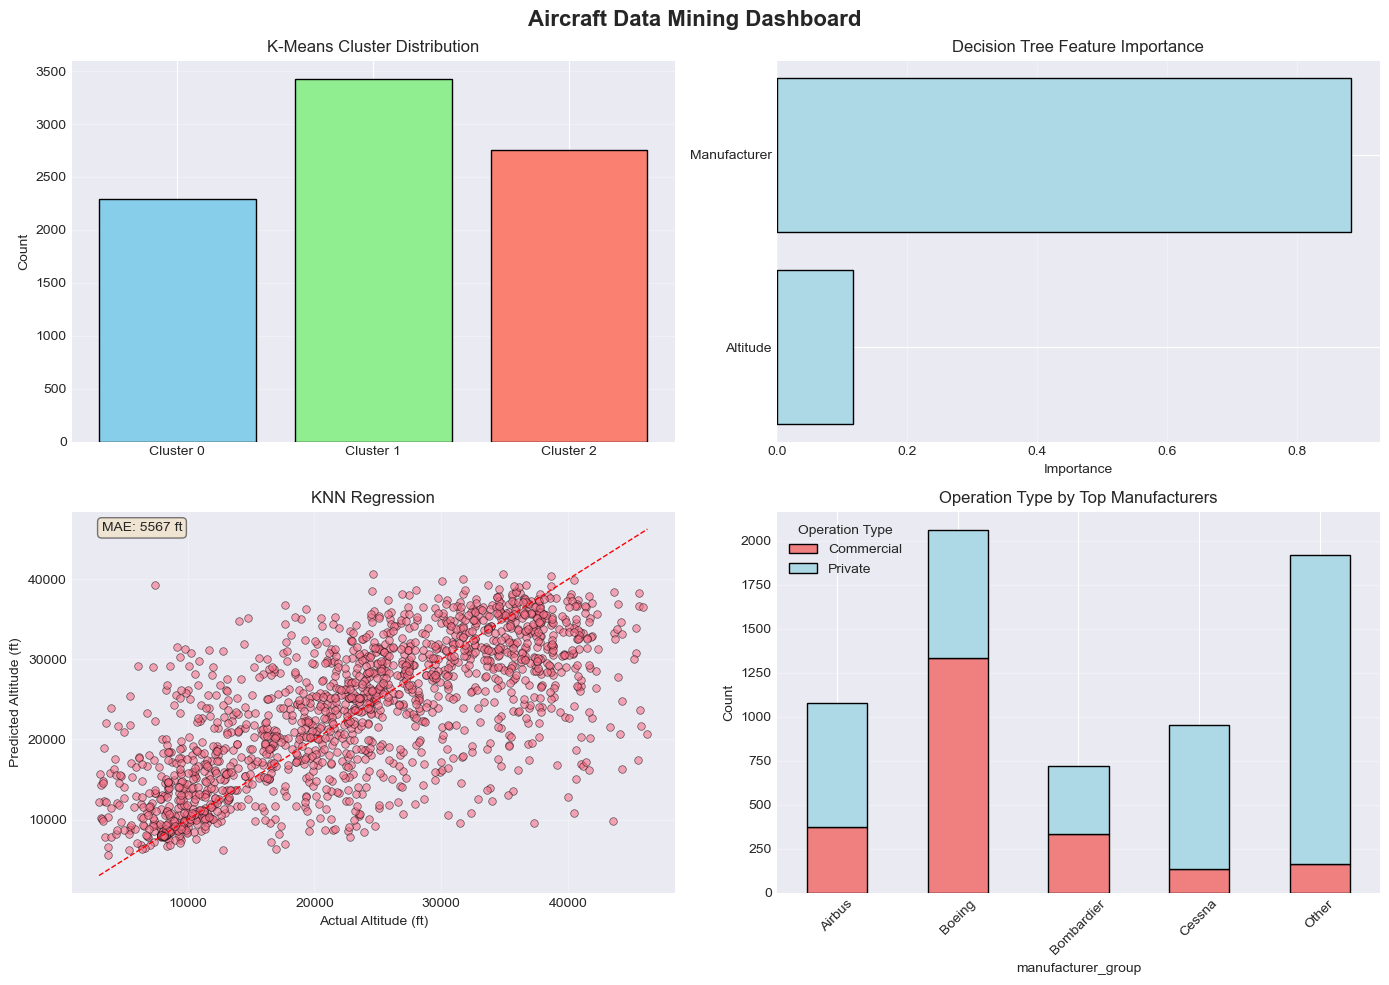

Dashboard shows: 1) Three altitude clusters, 2) Altitude is key classification feature,
3) KNN regression accuracy, 4) Manufacturer-operation patterns (Boeing/Airbus mostly commercial).


In [23]:
 fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Aircraft Data Mining Dashboard', fontsize=16, fontweight='bold')

# 1. Cluster Distribution
cluster_counts = df_clean['cluster'].value_counts().sort_index()
axes[0,0].bar(['Cluster 0', 'Cluster 1', 'Cluster 2'], cluster_counts.values, 
              color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')
axes[0,0].set_title('K-Means Cluster Distribution')
axes[0,0].set_ylabel('Count'); axes[0,0].grid(True, alpha=0.3, axis='y')

# 2. Feature Importance
axes[0,1].barh(['Altitude', 'Manufacturer'], dt.feature_importances_, color='lightblue', edgecolor='black')
axes[0,1].set_title('Decision Tree Feature Importance')
axes[0,1].set_xlabel('Importance'); axes[0,1].grid(True, alpha=0.3, axis='x')

# 3. Predicted vs Actual
axes[1,0].scatter(y_test_reg, y_pred_reg, alpha=0.6, s=30, edgecolor='black', linewidth=0.5)
max_val = max(y_test_reg.max(), y_pred_reg.max())
min_val = min(y_test_reg.min(), y_pred_reg.min())
axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
axes[1,0].set_xlabel('Actual Altitude (ft)'); axes[1,0].set_ylabel('Predicted Altitude (ft)')
axes[1,0].set_title('KNN Regression'); axes[1,0].grid(True, alpha=0.3)
axes[1,0].text(0.05, 0.95, f'MAE: {mae:.0f} ft', transform=axes[1,0].transAxes, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Operation Type by Manufacturer
top_mfg = df_clean['manufacturer_group'].value_counts().head(5).index
cross_tab = pd.crosstab(df_clean[df_clean['manufacturer_group'].isin(top_mfg)]['manufacturer_group'],
                       df_clean[df_clean['manufacturer_group'].isin(top_mfg)]['operation_type'])
cross_tab.plot(kind='bar', stacked=True, ax=axes[1,1], color=['lightcoral', 'lightblue'], edgecolor='black')
axes[1,1].set_title('Operation Type by Top Manufacturers'); axes[1,1].set_ylabel('Count')
axes[1,1].legend(title='Operation Type'); axes[1,1].grid(True, alpha=0.3, axis='y')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout(); plt.show()

print("Dashboard shows: 1) Three altitude clusters, 2) Altitude is key classification feature,")
print("3) KNN regression accuracy, 4) Manufacturer-operation patterns (Boeing/Airbus mostly commercial).")